## 房价缺失值的预测

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

In [2]:
house_df = pd.read_csv(r"./model_data/houses_all_set.csv", sep=",")

In [3]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9539 entries, 0 to 9538
Data columns (total 15 columns):
id               9539 non-null int64
region           9539 non-null object
city             9539 non-null object
rooms            9539 non-null int64
halls            9539 non-null int64
towards          9539 non-null object
decoration       9539 non-null int64
have_elevator    9539 non-null int64
visited          9539 non-null int64
attention        9539 non-null int64
publishday       9539 non-null float64
popular          9539 non-null float64
unit_price       9539 non-null float64
area             9539 non-null float64
total_price      8834 non-null float64
dtypes: float64(5), int64(7), object(3)
memory usage: 1.1+ MB


In [4]:
# 剔除 region 列，以便后续使用模型建模分析
house_df.drop(columns=['region'], axis=1, inplace=True)

In [5]:
house_df.tail()

,id,city,rooms,halls,towards,decoration,have_elevator,visited,attention,publishday,popular,unit_price,area,total_price
9534,9535,S,2,1,S,1,0,4,43,19.2,0.8177,2.6810,71.99,193.0
9535,9536,S,2,2,S,3,1,1,18,19.2,0.3177,3.9273,90.14,354.0
9536,9537,S,2,2,S N,1,0,21,24,19.2,1.1406,3.8193,77.24,295.0
9537,9538,S,4,2,S,2,0,0,20,19.2,0.3125,4.5806,181.20,830.0
9538,9539,S,2,2,S,3,1,1,66,19.2,1.0677,6.1422,98.50,605.0


In [6]:
# 以total_price是否为空，将数据分为两部分
house_df_train = house_df[house_df.total_price.notnull()]
house_df_test = house_df[house_df.total_price.isnull()]

In [7]:
house_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8834 entries, 1 to 9538
Data columns (total 14 columns):
id               8834 non-null int64
city             8834 non-null object
rooms            8834 non-null int64
halls            8834 non-null int64
towards          8834 non-null object
decoration       8834 non-null int64
have_elevator    8834 non-null int64
visited          8834 non-null int64
attention        8834 non-null int64
publishday       8834 non-null float64
popular          8834 non-null float64
unit_price       8834 non-null float64
area             8834 non-null float64
total_price      8834 non-null float64
dtypes: float64(5), int64(7), object(2)
memory usage: 1.0+ MB


In [8]:
house_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705 entries, 0 to 9330
Data columns (total 14 columns):
id               705 non-null int64
city             705 non-null object
rooms            705 non-null int64
halls            705 non-null int64
towards          705 non-null object
decoration       705 non-null int64
have_elevator    705 non-null int64
visited          705 non-null int64
attention        705 non-null int64
publishday       705 non-null float64
popular          705 non-null float64
unit_price       705 non-null float64
area             705 non-null float64
total_price      0 non-null float64
dtypes: float64(5), int64(7), object(2)
memory usage: 82.6+ KB


In [9]:
# 备份训练数据和测试数据
house_train = house_df_train.copy()
house_test = house_df_test.copy()

In [10]:
house_train['total_price'].describe()

count    8834.000000
mean      398.201777
std       353.192711
min        22.300000
25%       190.000000
50%       295.000000
75%       460.000000
max      4000.000000
Name: total_price, dtype: float64

## 二元变量分析

In [11]:
# 设置matplotlib正常显示中文和负号，用黑体显示中文 
matplotlib.rcParams['font.sans-serif']=['SimHei'] 
matplotlib.rcParams['axes.unicode_minus']=False 

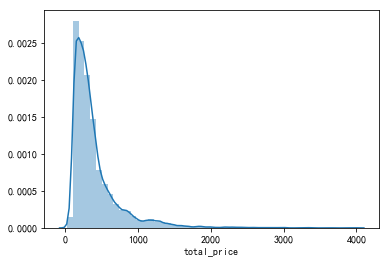

In [12]:
# 绘制 total_rice 的频率直方图
sns.distplot(house_train['total_price'])

In [13]:
print("偏态系数: %f" % house_train['total_price'].skew())
print("峰态系数: %f" % house_train['total_price'].kurt())

偏态系数: 3.163708
峰态系数: 15.171512


### 二元变量特征分析

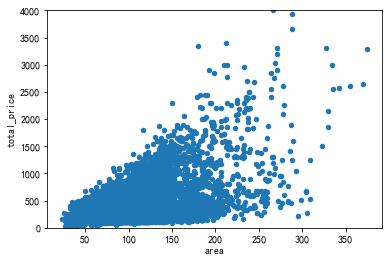

In [14]:
# Area 与 total_price 的散点图
var = 'area'
data = pd.concat([house_train[var], house_train['total_price']], axis=1)
data.plot.scatter(x=var, y='total_price', ylim=(0,4000));

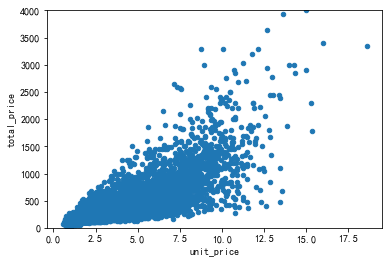

In [15]:
# unit_price 与 total_price 的散点图
var = 'unit_price'
data = pd.concat([house_train[var], house_train['total_price']], axis=1)
data.plot.scatter(x=var, y='total_price', ylim=(0,4000));

 - 有以上图示结果可知，unit_price和 area 对于总价的散点图均呈现圆锥形分布（坐下段分布集中，右上段分布分散），需要做进一步处理。

## 分布的直方图和正态概率图

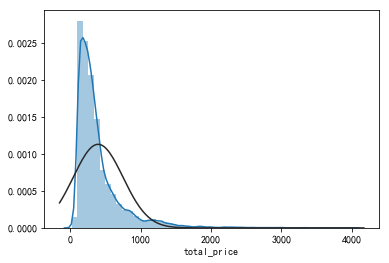

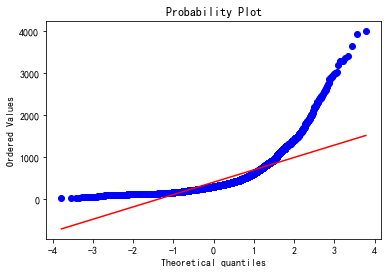

In [16]:
# 直方图和正态概率图
sns.distplot(house_train['total_price'], fit=norm);
fig = plt.figure()
res = stats.probplot(house_train['total_price'], plot=plt);

 -  根据以上概率分布图可看出，分布具有明显的偏态趋势，需要使用 np.log 对其进行对数化处理

In [17]:
# 对total_price 字段进行对数化，使其取值在一个较小的区间内
house_train['total_price'] = np.log(house_train['total_price'])

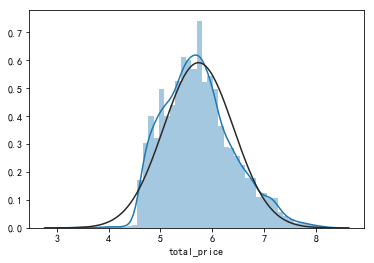

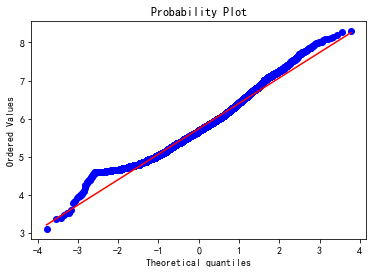

In [18]:
# np.log 转换之后的直方图和概率分布图
sns.distplot(house_train['total_price'], fit=norm);
fig = plt.figure()
res = stats.probplot(house_train['total_price'], plot=plt)
plt.show();

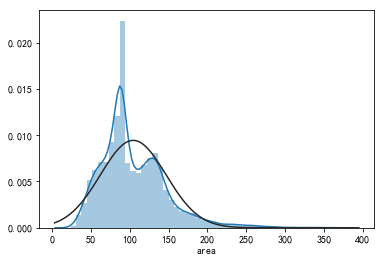

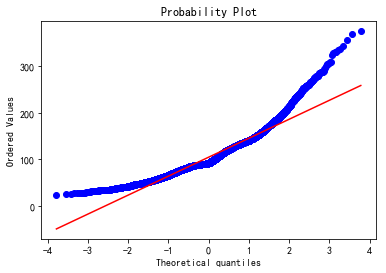

In [19]:
# area 直方图和正态概率图
sns.distplot(house_train['area'], fit=norm);
fig = plt.figure()
res = stats.probplot(house_train['area'], plot=plt)
plt.show();

In [20]:
# 对 area 字段进行对数化，使其取值在一个较小的区间内
house_train['area'] = np.log(house_train['area'])

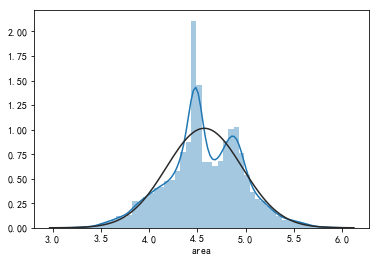

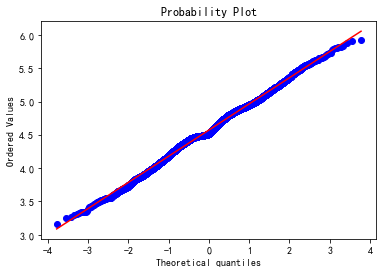

In [21]:
# np.log 转换之后的 area 直方图和概率分布图
sns.distplot(house_train['area'], fit=norm);
fig = plt.figure()
res = stats.probplot(house_train['area'], plot=plt)
plt.show();

 - np.log 对数化处理之后的散点图预览

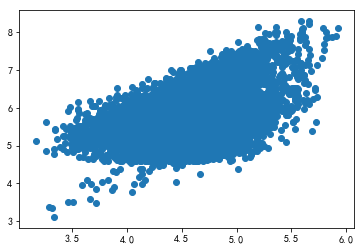

In [22]:
# 绘制对数化后的 area和 total_price的散点图
plt.scatter(house_train['area'], house_train['total_price'])
plt.show();

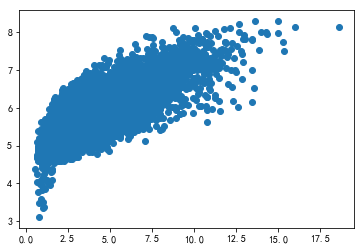

In [23]:
# 绘制对数化后的 unit_price 和 total_price的散点图
plt.scatter(house_train['unit_price'], house_train['total_price']);

In [24]:
house_train.head()

,id,city,rooms,halls,towards,decoration,have_elevator,visited,attention,publishday,popular,unit_price,area,total_price
1,2,K,3,2,SE,3,0,0,0,19.0,0.0000,1.3446,4.779123,5.075174
2,3,K,3,2,SE,2,0,0,0,19.0,0.0000,1.1021,4.990433,5.087596
3,4,K,4,2,SE,2,0,1,1,15.0,0.0667,1.4477,4.653960,5.023881
4,5,K,3,2,S N,0,0,1,3,19.0,0.0842,1.8196,4.860975,5.459586
5,6,K,3,2,S N,1,0,1,1,4.0,0.2500,1.2723,4.546693,4.787492


### 测试数据集的处理

In [25]:
# area 直方图和正态概率图
# sns.distplot(house_test['area'], fit=norm);
# fig = plt.figure()
# res = stats.probplot(house_test['area'], plot=plt)
# plt.show();

In [26]:
# 对测试集 area 字段进行对数化，使其取值在一个较小的区间内
house_test['area'] = np.log(house_test['area'])

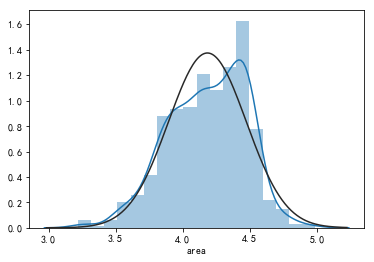

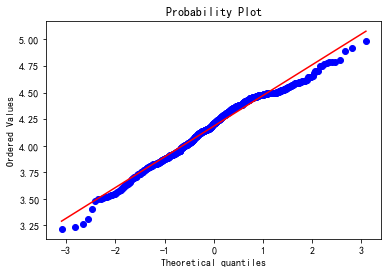

In [27]:
# np.log 转换之后的 area 直方图和概率分布图
sns.distplot(house_test['area'], fit=norm);
fig = plt.figure()
res = stats.probplot(house_test['area'], plot=plt)
plt.show();

In [28]:
house_test.head()

,id,city,rooms,halls,towards,decoration,have_elevator,visited,attention,publishday,popular,unit_price,area,total_price
0,1,K,2,2,SE NW,0,0,6,9,19.0,0.3632,1.3000,3.912023,NaN
9,10,K,2,1,SW,0,0,1,3,15.0,0.1067,1.0134,4.012049,NaN
15,16,K,3,2,S N,0,0,0,0,8.0,0.0000,0.9767,4.534533,NaN
35,36,K,1,0,S N,0,0,0,0,14.0,0.0000,2.4586,3.654288,NaN
37,38,K,2,1,E W,0,0,0,1,11.0,0.0273,2.0000,3.688879,NaN
